In [1]:
import numpy as np
import sys
from scipy import linalg

sys.path.append('../code/')
from sbi import NeuralRatioEstimator

from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 12 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of NeuralRatioEstimator
### simple NRE using Sequential NN tested on linear Gaussian problem

## Simulator setup

In [3]:
nparam = 2
ndata = 10

class MyNRE(NeuralRatioEstimator):
    def __init__(self,params={}):
        NeuralRatioEstimator.__init__(self,params=params)

        # data variables and noise
        self.xvals = np.linspace(-1,2,ndata)
        self.sigma = np.linspace(0.1,0.5,ndata)

        # prior mean,std
        self.prior_mean = np.array([0.0,0.0])
        self.prior_std = np.array([20.0,20.0])
        
        # # prior bounds
        # self.theta_min = np.array([-10.0,-3.0])
        # self.theta_max = np.array([10.0,3.0])
        # self.dtheta = self.theta_max - self.theta_min        

        return
    
    def simulator(self,theta):
        out = np.zeros((self.xvals.size,theta.shape[1]))
        ####################
        # straight line
        for x in range(self.xvals.size):
            out[x] = theta[0] + theta[1]*self.xvals[x]
        ####################
            
        noise = self.rng.randn(out.shape[0],out.shape[1])
        noise = (noise.T*self.sigma).T
        out += noise
        
        return out

    def prior(self,nsamp):
        theta = np.zeros((2,nsamp))

        # for p in range(theta.shape[0]):
        #     theta[p] = self.theta_min[p] + self.rng.rand(nsamp)*self.dtheta[p]
        
        for p in range(theta.shape[0]):
            theta[p] = self.prior_mean[p] + self.rng.randn(nsamp)*self.prior_std[p]
            
        return theta

## Analytical ratio for linear Gaussian problem
#### with design matrix $\mathcal{M}$, data $y$, data covariance $C$, prior inverse covariance $F_{\rm (p)}$, prior mean $\theta_{\rm (p)}$, we have
#### $F = \mathcal{M}^{\rm T}C^{-1}\mathcal{M} + F_{\rm (p)}$
#### $\hat\theta = F^{-1}\left(\mathcal{M}^{\rm T}C^{-1}y + F_{\rm (p)}\theta_{\rm (p)}\right)$
#### $-2\ln p(\theta|x) = (\theta-\hat\theta)^{\rm T}\,F\,(\theta-\hat\theta) - \ln{\rm det}F + M\ln(2\pi)$
#### $-2\ln p(\theta) = (\theta-\theta_{\rm (p)})^{\rm T}\,F_{\rm (p)}\,(\theta-\theta_{\rm (p)}) - \ln{\rm det}F_{\rm (p)} + M\ln(2\pi)$
#### $2\ln r(y,\theta) = (\mathcal{M}\theta)^{\rm T}C^{-1}(y-\mathcal{M}\theta) + \left(\mathcal{M}(\theta-\hat\theta)\right)^{\rm T}C^{-1}y - (\hat\theta-\theta_{\rm (p)})^{\rm T}F_{\rm (p)}\theta_{\rm (p)} + \ln{\rm det}FF_{\rm (p)}^{-1}$

In [4]:
def analytical_nre(nre,X,theta):
    designM = np.ones((nre.ndata,nre.nparam))
    designM[:,1] = nre.xvals
    F_p = np.diagflat(1/nre.prior_std**2)
    theta_p = nre.cv(nre.prior_mean)
    Cinv = np.diagflat(1/nre.sigma**2)
    F = F_p + np.dot(designM.T,np.dot(Cinv,designM))
    theta_hat = np.dot(F_p,theta_p)
    theta_hat += np.dot(designM.T,np.dot(Cinv,X))
    theta_hat = np.dot(linalg.inv(F),theta_hat)

    Mtheta = np.dot(designM,theta)
    Mtheta_hat = np.dot(designM,theta_hat)

    lnr = np.dot(Mtheta.T,np.dot(Cinv,X-Mtheta))
    lnr += np.dot((Mtheta-Mtheta_hat).T,np.dot(Cinv,X))
    lnr -= np.dot((theta_hat-theta_p).T,np.dot(F_p,theta_p))
    lnr += np.log(linalg.det(F)) - np.log(linalg.det(F_p))
    lnr *= 0.5
    ratio = np.exp(lnr)    
    return ratio

## NRE setup and training

In [64]:
Train = False
Lh = 4
L_tanh = 2 # 2 # number of layers with tanh activation
Standardize = True

if L_tanh > Lh:
    raise Exception('need L_tanh <= Lh')

File_Stem = 'line'
params = {'param_dim':nparam,'data_dim':ndata,'standardize':Standardize,
          'Lh':Lh,'n_hidden_layer':[120]*Lh,'hidden_atypes':['lrelu']*(Lh-L_tanh)+['tanh']*L_tanh,
          'file_stem':File_Stem}

start_time = time()
nre = MyNRE(params=params)

if Train:
    NSamp = 2000
    params_train = {'max_epoch':1000,'lrate':1e-3,'mb_count':int(np.sqrt(0.8*NSamp)),'val_frac':0.2,'check_after':500}
    nre.train(NSamp,params=params_train)
    nre.save()
else:
    nre.load()
nre.time_this(start_time)

... setting up 5 layer feed-forward neural network
... ... expecting data dim = 12, target dim = 1
... ... using hidden layers of sizes [120,120,120,120]
... ... ... and activations [lrelu,lrelu,tanh,tanh]
... ... using last activation layer 'sigm'
... ... ... with threshold (None means default): None
... ... leaky ReLU will use slope = 1.00e-02
... ... using loss function 'nll'
... ... not using any regularization
... ... not using any weight decay
0 min 0.01 seconds



In [65]:
if Train:
    plt.yscale('log')
    plt.plot(nre.net.epochs,nre.net.epoch_loss,'k-')
    plt.plot(nre.net.epochs,nre.net.val_loss,'r-')
    plt.show()

## Data

In [66]:
# theta_true = np.array([[1.0,-1.0]]).T # y = 1 - x
# data = nre.simulator(theta_true)

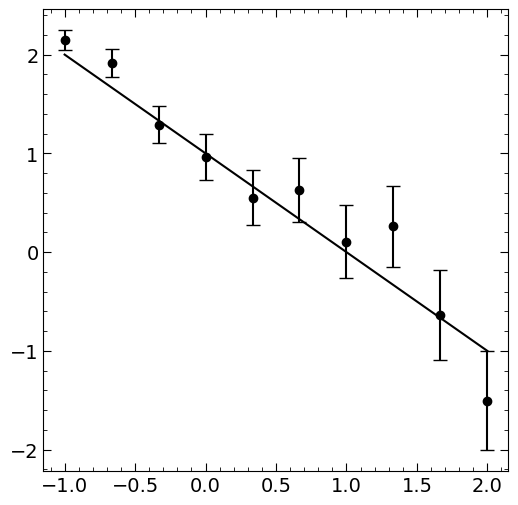

In [67]:
plt.figure(figsize=(6,6))
plt.errorbar(nre.xvals,data.T[0],yerr=nre.sigma,c='k',capsize=5,marker='o',ls='none')
plt.plot(nre.xvals,theta_true[0,0] + theta_true[1,0]*nre.xvals,'k-')
plt.minorticks_on()
plt.show()

In [68]:
theta_test = theta_true.copy()
print('analytical: {0:.3e}'.format(np.squeeze(analytical_nre(nre,data,theta_test))))
print('predicted : {0:.3e}'.format(np.squeeze(nre.predict(data,theta_test))))

analytical: 1.101e+04
predicted : 1.210e+04


In [63]:
1.101e+04/1.210e+04

0.9099173553719008